### MLflow - bank customer data analysis - marketing target model efficiency and productionisation

In [3]:
# !pip install shap
# !pip install -U imbalanced-learn


In [4]:
# library for feature engineering and EDA  
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# library for sampling 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap 

# Enabling inline plotting for matplotlib, so plots are displayed directly in the notebook
%matplotlib inline

### 1. Data Processing 1

In [1]:
# mlflow path should be the same.
%pwd 
random_state = 42

In [5]:
df = pd.read_csv('data/bank-additional-full.csv', delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
# Check duplicate entries
print("Number of duplicate entries:", len(df[df.duplicated()]))

Number of duplicate entries: 12


In [10]:
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [11]:
# Remove duplicate entries
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [12]:
# removed duplicated entires mess up the index
df = df.reset_index(drop=True)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [9]:
print("중복된 항목 수 :", len(df[df.duplicated()])) 

중복된 항목 수 : 0


In [13]:
# Int64 doesn't mean always numerical, object doesn't mean always categorical
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [14]:
# check if int64 is really numerical, object is really categorical
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

age int64 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job object ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital object ['married' 'single' 'divorced' 'unknown']
education object ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default object ['no' 'unknown' 'yes']
housing object ['no' 'yes' 'unknown']
loan object ['no' 'yes' 'unknown']
contact object ['telephone' 'cellular']
month object ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week object ['mon' 'tue' 'wed' 'thu' 'fri']
duration int64 [ 261  149  226 ... 1246 1556 1868]
campaign int64 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 

In [15]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "y"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

41176
21
11
10


In [16]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Dependent Varialble exploration

In [17]:
# target_column == y. added into categorical column. Needto remove it.
list_categorical_columns.remove(target_column)

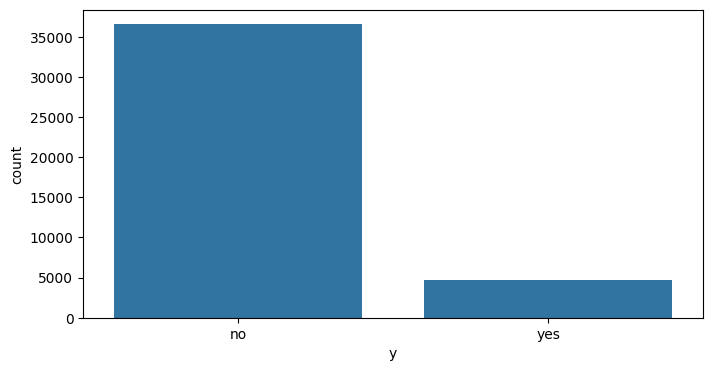

In [25]:
# no 36537, yes 5000
df[target_column].describe()
df[target_column].value_counts()
plt.figure(figsize=(8, 4))
sns.countplot(x=target_column, data=df)
plt.show()

### Imbalance dataset
1. Oversampling // Undersampling // Combined
2. ML algorithm based, cost-sensitive learning
3. 

### Independent Variables

In [27]:
# if nunique is 1, then it's not meaningful.
df[list_categorical_columns].nunique().sort_values()

contact         2
default         3
housing         3
loan            3
poutcome        3
marital         4
day_of_week     5
education       8
month          10
job            12
dtype: int64

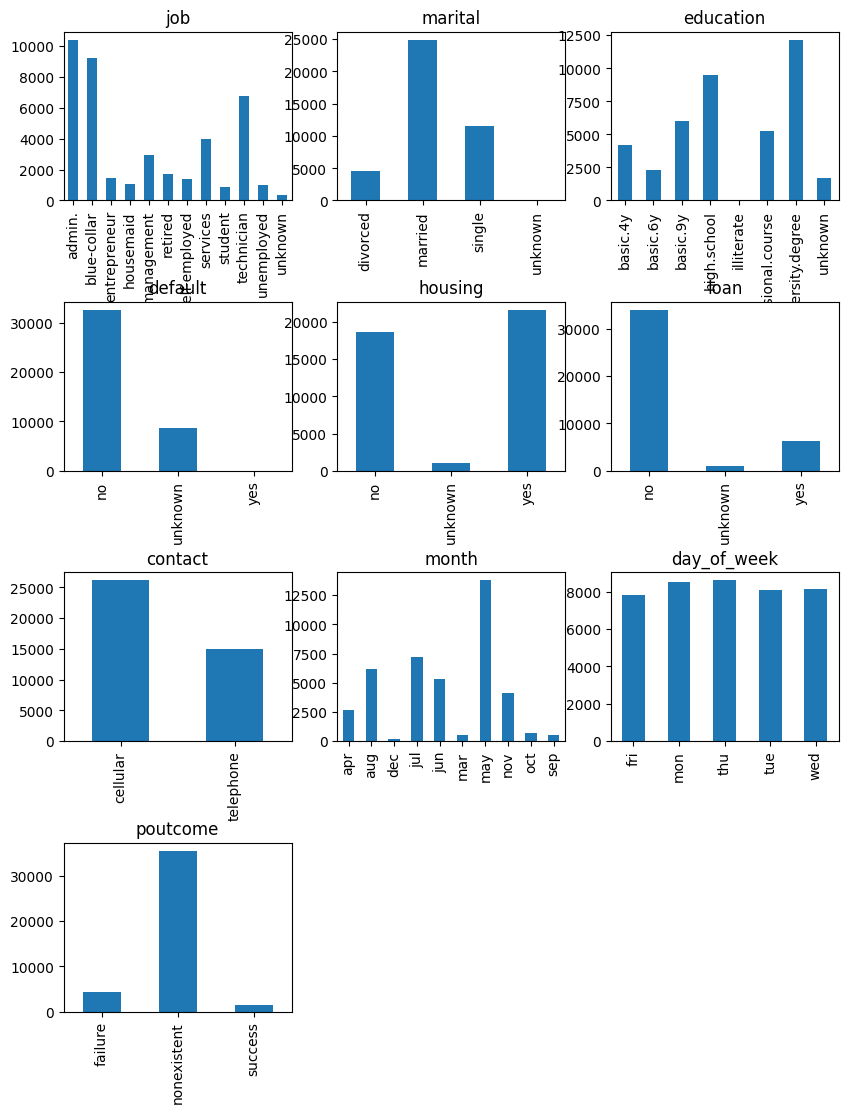

In [28]:
plt.figure(figsize=(10, 10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6, wspace=0.2) # Create subplots
for column_name in list_categorical_columns: # each column_name
    plt.subplot(4,3,x) # subplot, 4 rows 3 columns.
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar') #value_counts shows the unique values and their counts.
    # sort index to make it look good.
    plt.title(column_name)
plt.show()

### check the correlation between target column and categorical column

<Axes: xlabel='y'>

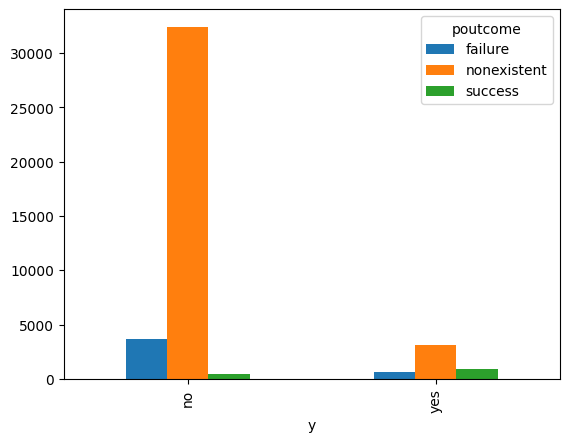

In [29]:
df_poutcome_dependent = pd.crosstab(df[target_column], df[list_categorical_columns[-1]])
df_poutcome_dependent.plot(kind='bar')
# Too many 'No' comparing to 'Yes'. Ratio would be more appropriate.


In [30]:
pd.crosstab(df[target_column], df[list_categorical_columns[-1]])

poutcome,failure,nonexistent,success
y,,,
no,3647,32411,479
yes,605,3140,894


In [32]:
# Normalize based on index.
pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize='index')


poutcome,failure,nonexistent,success
y,,,
no,0.099817,0.887073,0.013110
yes,0.130416,0.676870,0.192714


<Axes: xlabel='y'>

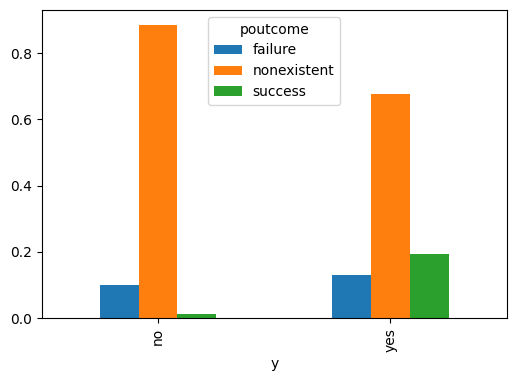

In [33]:
df_poutcome_dependent_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize='index')
df_poutcome_dependent_ratio.plot.bar(figsize=(6, 4))



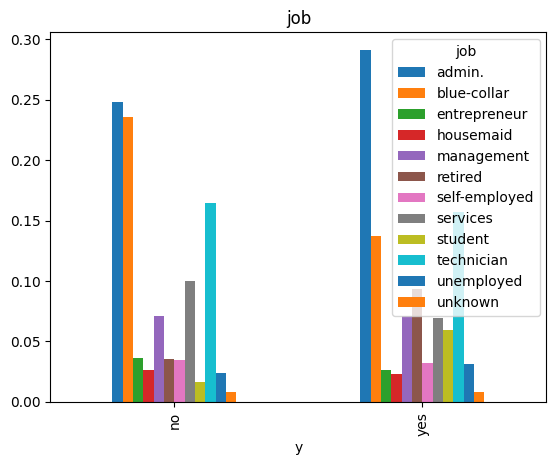

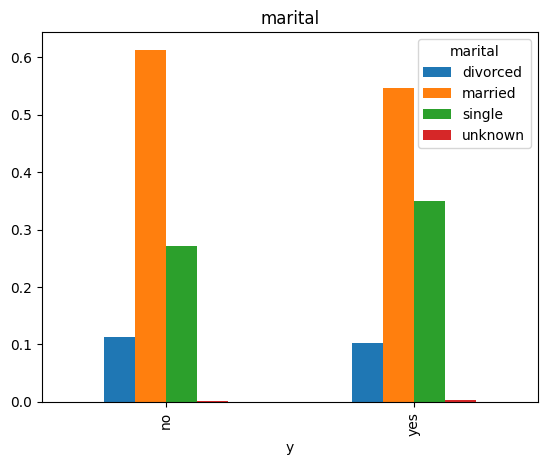

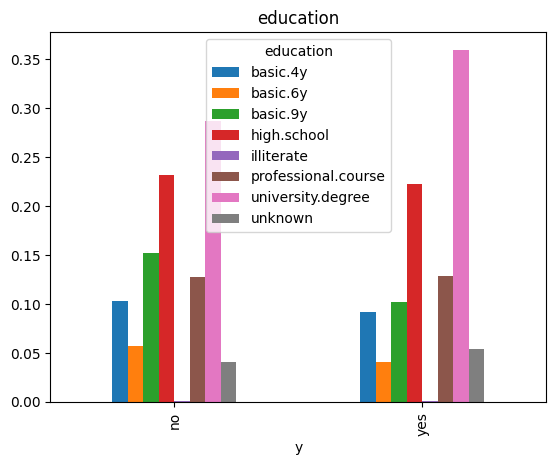

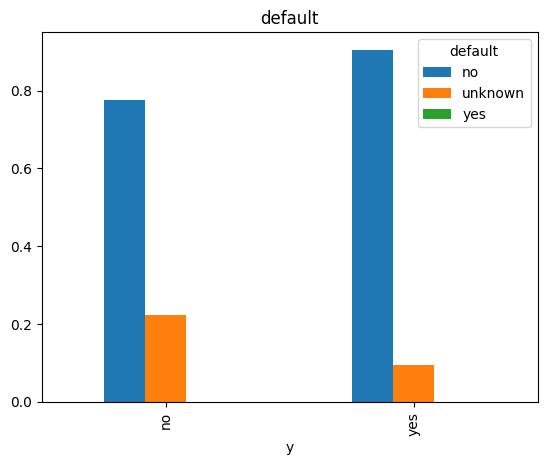

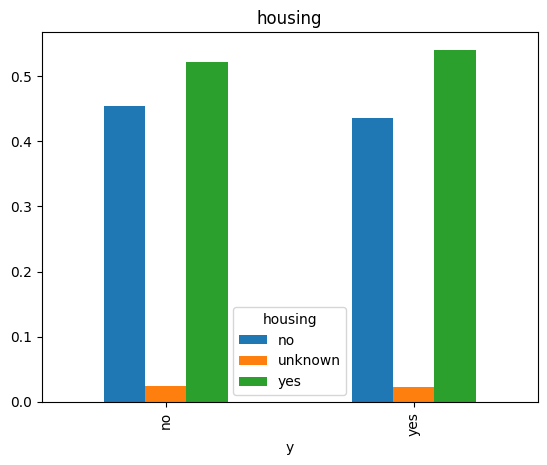

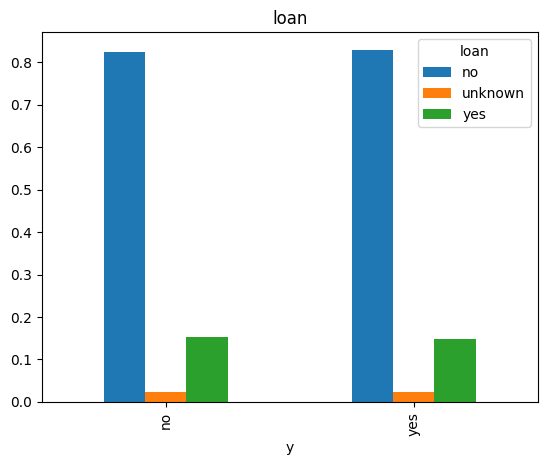

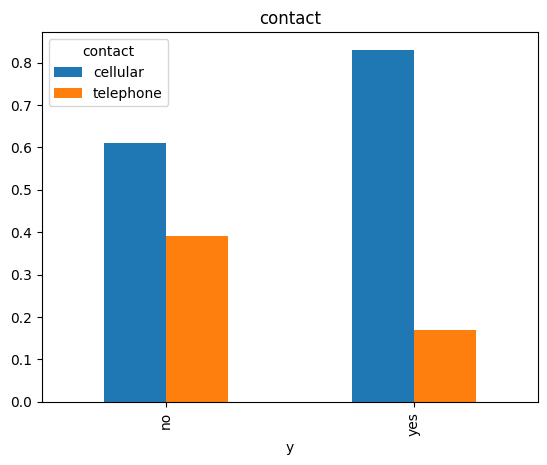

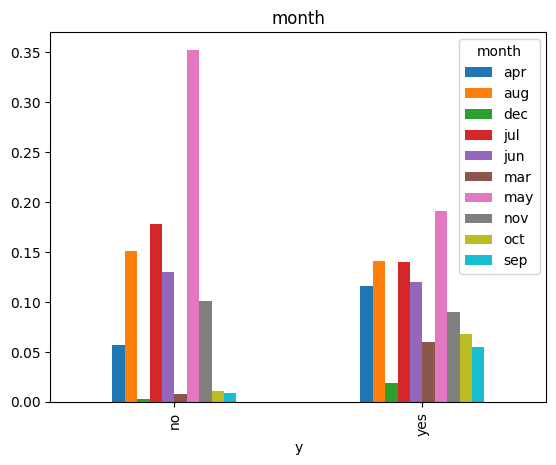

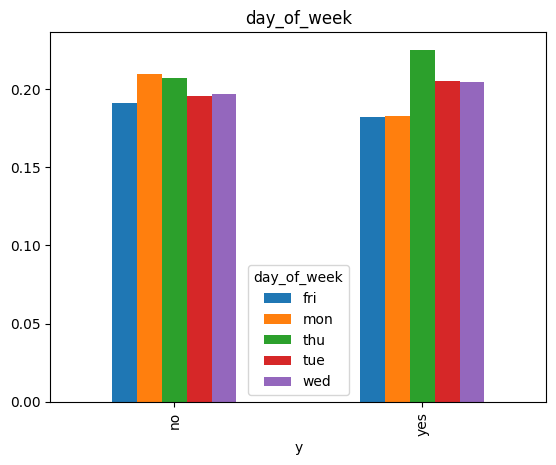

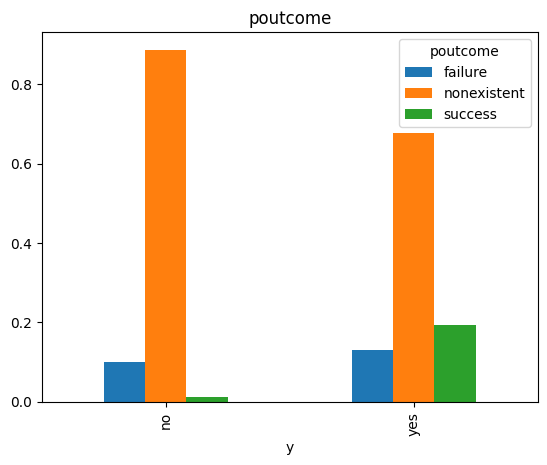

In [39]:
# Check every column name
for column_name in list_categorical_columns:
    pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()


Chisqaure-test  
Two categorical variables (target column and job/age/loan/housing etc)  
1. Goodness of fit (Check known factor, if it's true)  
**2. Test of independence (Check if two categorical variables are related. Are they independent or not)**  
3. Test of Homogeneity (Check if those two groups are similar/the same category etc.)

In [25]:
list_meaningful_column_by_chi = []

for column_name in list_categorical_columns: #categrical columns.
    statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name])) # adding this table values. This returns statistics and pvalue
    if pvalue <= 0.05:
        list_meaningful_column_by_chi.append(column_name)
    print(column_name, statistic, pvalue)
    
print("all categorical columns: ", len(list_categorical_columns))
print("selected columns by chi: ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)
# As a result, 8 features are related. Housing and Loan are not related.


job 961.7438037353177 3.2684116066165443e-199
marital 122.95931379226256 1.778422500461116e-26
education 192.8485047401879 3.746768377534744e-38
default 406.5560941574606 5.217540893727963e-89
housing 5.742152842222754 0.05663792749452546
loan 1.0992950447716308 0.5771532081176227
contact 862.0807365848323 1.7187406241263767e-189
month 3103.032672105299 0.0
day_of_week 26.054243692750852 3.085754965631736e-05
poutcome 4230.14342770359 0.0
all categorical columns:  10
selected columns by chi:  8 ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']


### Numerical data check

In [40]:
df[list_numeric_columns].nunique().sort_values()

previous             8
emp.var.rate        10
nr.employed         11
cons.price.idx      26
cons.conf.idx       26
pdays               27
campaign            42
age                 78
euribor3m          316
duration          1544
dtype: int64

In [41]:
df[list_numeric_columns].describe()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


: 

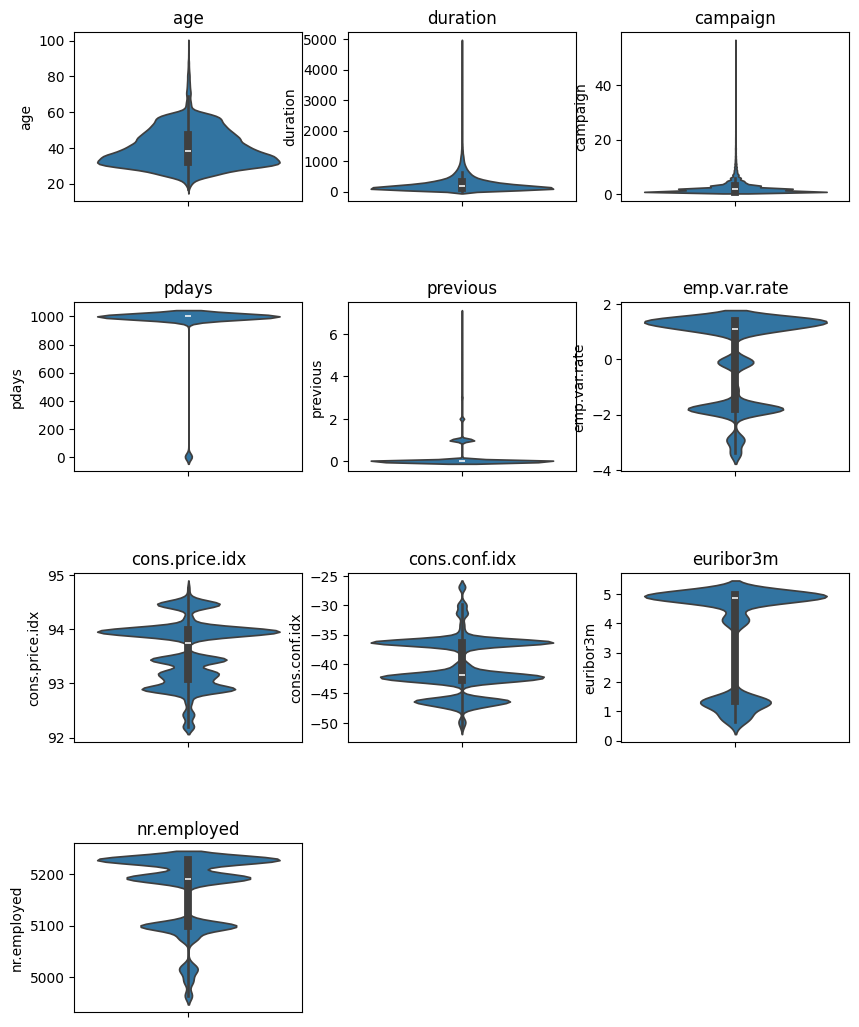

In [27]:
# numeric column distribution
plt.figure(figsize=(10, 10))
x = 1

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)

for column_name in list_numeric_columns:
    plt.subplot(4,3,x)
    x = x+1
    sns.violinplot(df[column_name]) # or box plot.
    plt.title(column_name)
plt.show()
    

In [28]:
for column_name in list_numeric_columns:
    print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]))
    


age skew :  0.7845316793906337 kur :  0.7908715485573286
duration skew :  3.2626886475171046 kur :  20.241167105999835
campaign skew :  4.76187058291751 kur :  36.96722235388976
pdays skew :  -4.921207099141221 kur :  22.21870880664178
previous skew :  3.8312559388497256 kur :  20.09957712427588
emp.var.rate skew :  -0.7240342146771608 kur :  -1.062714697365619
cons.price.idx skew :  -0.2308444969439891 kur :  -0.8298960161833482
cons.conf.idx skew :  0.3028649665515025 kur :  -0.3591991612497849
euribor3m skew :  -0.7091683770703301 kur :  -1.4067662115952242
nr.employed skew :  -1.0442790133772375 kur :  -0.0036849526898108387


<Axes: >

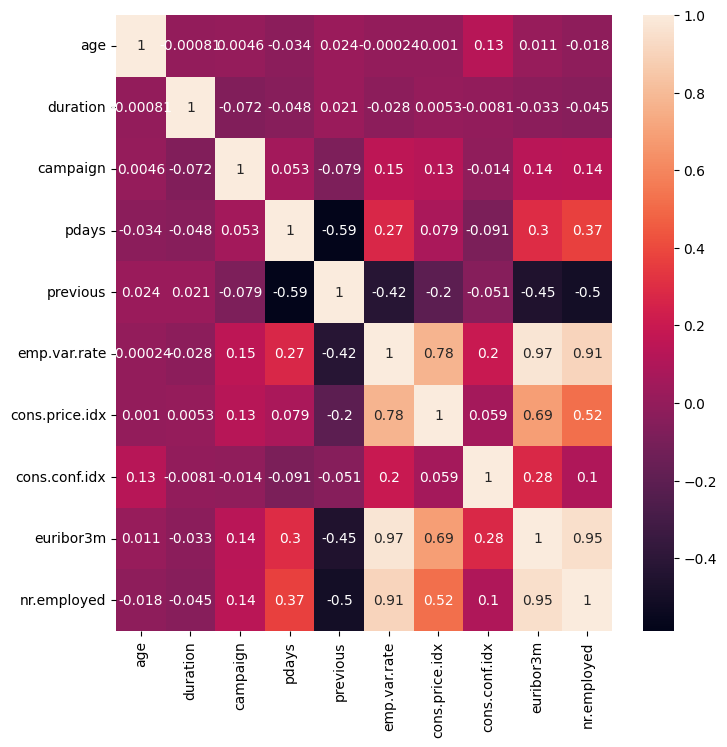

In [29]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)

In [30]:
index_corr_over_75 = np.where((abs(df_corr)>0.75) & (df_corr != 1))
index_corr_over_75


(array([5, 5, 5, 6, 8, 8, 9, 9], dtype=int64),
 array([6, 8, 9, 5, 5, 9, 5, 8], dtype=int64))

In [31]:
len_corr_over_75 = len(index_corr_over_75[0])
left_columns = df_corr.columns[index_corr_over_75[0]]
right_columns = df_corr.columns[index_corr_over_75[1]]
for index in range(len_corr_over_75):
    print(left_columns[index], "<->", right_columns[index])


emp.var.rate <-> cons.price.idx
emp.var.rate <-> euribor3m
emp.var.rate <-> nr.employed
cons.price.idx <-> emp.var.rate
euribor3m <-> emp.var.rate
euribor3m <-> nr.employed
nr.employed <-> emp.var.rate
nr.employed <-> euribor3m


In [32]:
list_not_valid = []
for index in range(len_corr_over_75):
    statistic, pvalue = stats.pearsonr(df.loc[:,left_columns[index]], df.loc[:,right_columns[index]])
    print("%s<->%s : %f:%f"%(left_columns[index], right_columns[index], statistic, pvalue))
    if (pvalue > 0.05):
        list_not_valid.append(column_name)

print("end")
print(len(list_not_valid), " is not valids")


emp.var.rate<->cons.price.idx : 0.775293:0.000000
emp.var.rate<->euribor3m : 0.972244:0.000000
emp.var.rate<->nr.employed : 0.906949:0.000000
cons.price.idx<->emp.var.rate : 0.775293:0.000000
euribor3m<->emp.var.rate : 0.972244:0.000000
euribor3m<->nr.employed : 0.945146:0.000000
nr.employed<->emp.var.rate : 0.906949:0.000000
nr.employed<->euribor3m : 0.945146:0.000000
end
0  is not valids


In [33]:
list_removed_by_correlation = ["emp.var.rate", "euribor3m"]

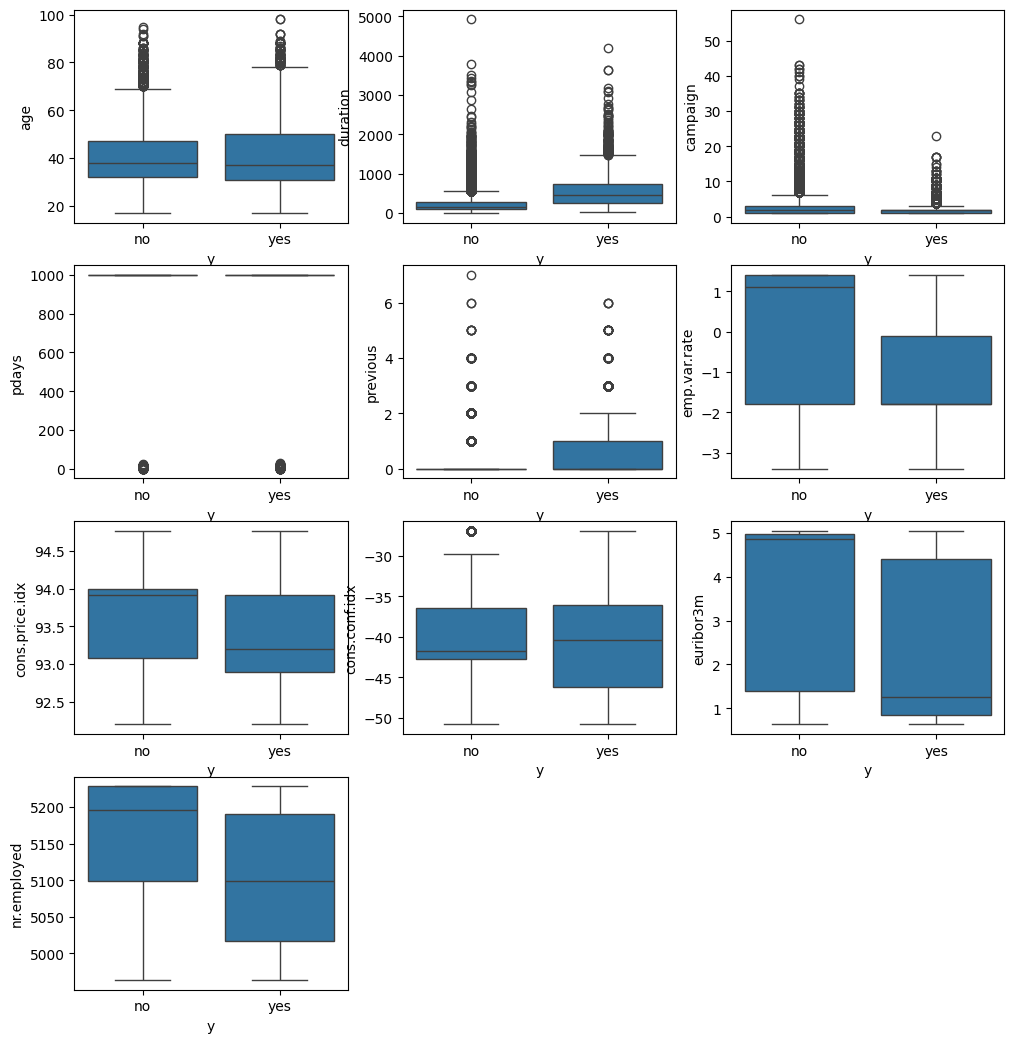

In [34]:
plt.figure(figsize=(12,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom= 0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,3,x)
    x = x + 1
    sns.boxplot(data=df, x=target_column, y=column_name)

plt.show()
    

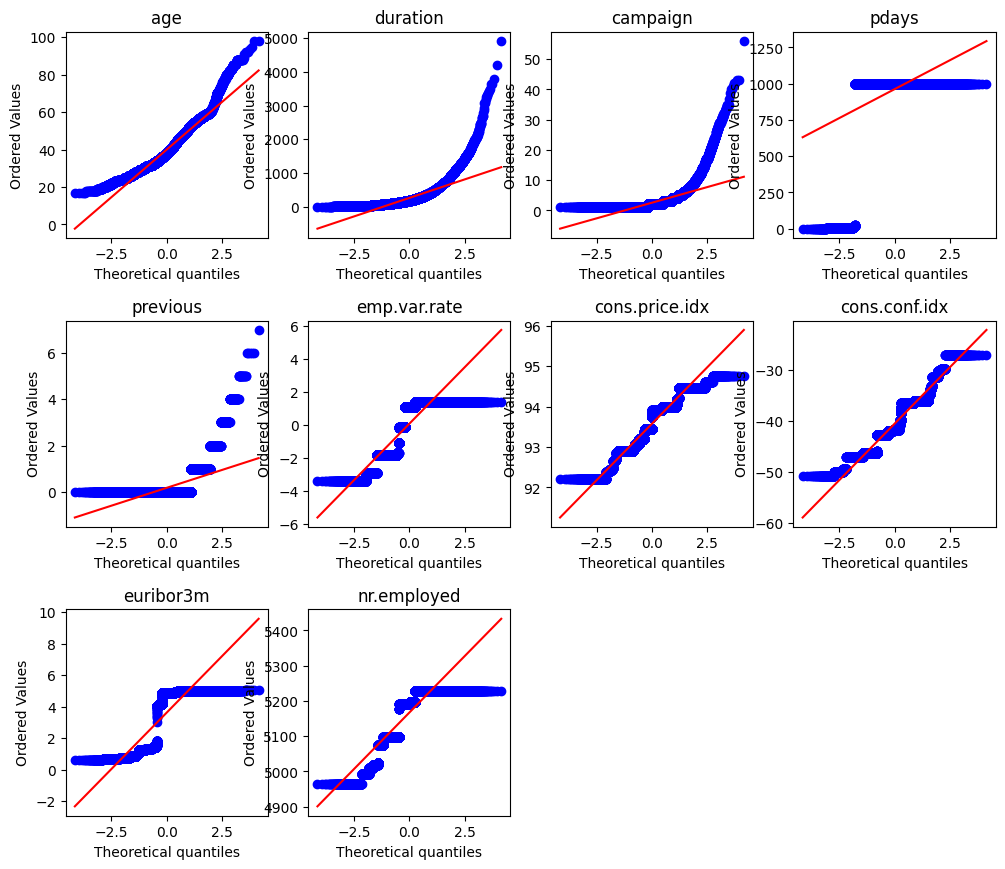

In [35]:
plt.figure(figsize=(12,8))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,4,x)
    x = x+1
    
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    
    plt.title(column_name)
plt.show()

In [36]:
list_column_normality = []
for column_name in list_numeric_columns:
    statistic, pvalue = stats.shapiro(df[column_name])
    if pvalue > 0.05:
        list_column_normality.append(column_name)
    print(column_name, ", statistic: ",statistic,", pvalue : ", pvalue)
print("number of columns meet normality : ", len(list_column_normality))

age , statistic:  0.9572418694380834 , pvalue :  5.505594726721474e-73
duration , statistic:  0.721679918747429 , pvalue :  1.844733714177967e-119
campaign , statistic:  0.5578708971640653 , pvalue :  9.843934759782558e-133
pdays , statistic:  0.18300671121201462 , pvalue :  1.9467747860319456e-151
previous , statistic:  0.3913039514675606 , pvalue :  2.5713622808966146e-142
emp.var.rate , statistic:  0.7620850923718743 , pvalue :  4.0112031623071492e-115
cons.price.idx , statistic:  0.9339593598057025 , pvalue :  9.779875324999567e-83
cons.conf.idx , statistic:  0.9239596325156416 , pvalue :  4.938368882631235e-86
euribor3m , statistic:  0.6862663568831273 , pvalue :  7.928858157839837e-123
nr.employed , statistic:  0.7875882921336348 , pvalue :  4.87329710160513e-112
number of columns meet normality :  0


scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41176.


In [37]:
list_meaningful_column_by_kruskall = []

list_target_unique = df[target_column].unique() # 

for column_name in list_numeric_columns:
    list_by_target_value = []
    for target_value in list_target_unique:
        df_tmp = df[df[target_column]==target_value][column_name].dropna()
        list_by_target_value.append(np.array(df_tmp))
    statistic, pvalue = kruskal(*list_by_target_value)
    if pvalue <= 0.05:
        list_meaningful_column_by_kruskall.append(column_name)
    print(column_name, ",", statistic, ", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskall : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)
    

age , 5.843156420996497 ,  0.015637749222475184
duration , 5008.952641567334 ,  0.0
campaign , 166.83794105975488 ,  3.629350163987945e-38
pdays , 4348.437887965406 ,  0.0
previous , 1662.3956401363578 ,  0.0
emp.var.rate , 2520.7461098911913 ,  0.0
cons.price.idx , 614.0899232769726 ,  1.4427370342045907e-135
cons.conf.idx , 69.64459433834713 ,  7.101309014386373e-17
euribor3m , 2930.314757187436 ,  0.0
nr.employed , 3318.9556210068745 ,  0.0
all numerical columns :  10
selected columns by kruskall :  10 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [38]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [39]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()
for column_name in list_removed_by_correlation:
    list_selected_numerical.remove(column_name)

In [40]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical + [target_column]]
df_fs.head(2)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,56,261,1,999,0,93.994,-36.4,5191.0,no
1,services,married,high.school,unknown,telephone,may,mon,nonexistent,57,149,1,999,0,93.994,-36.4,5191.0,no


In [41]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [42]:
Y

0         no
1         no
2         no
3         no
4         no
        ... 
41171    yes
41172     no
41173     no
41174    yes
41175     no
Name: y, Length: 41176, dtype: object

In [43]:
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [44]:
Y_encoded

array([0, 0, 0, ..., 0, 1, 0])

In [45]:
le.inverse_transform(Y_encoded)

array(['no', 'no', 'no', ..., 'no', 'yes', 'no'], dtype=object)

In [46]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

9
8


In [47]:
df_fs.head(1)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,56,261,1,999,0,93.994,-36.4,5191.0,no


In [48]:
scaler = MinMaxScaler()
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,0.481481,0.05307,0.0,1.0,0.0,0.698753,0.60251,0.859735


In [49]:
X_base = pd.get_dummies(X)
X_base.head(1)

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.481481,0.05307,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0


In [50]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

### Model Optimisation

In [51]:
# !pip install mlflow

import mlflow

# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.create_experiment("bank_marketing_model")

In [52]:
mlflow.set_experiment("bank_marketing_model")

<Experiment: artifact_location='file:///c:/Users/TaeyoonKim/10-MLOps-Challenge/Banking_marketing/mlruns/162997116162893466', creation_time=1741267680295, experiment_id='162997116162893466', last_update_time=1741267680295, lifecycle_stage='active', name='bank_marketing_model', tags={}>

In [53]:
# !pip install torch torchvision torchaudio

Split 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0  precision, recall, f1score :  (0.7953282653069478, 0.7332668663056062, 0.759194728427572, None)
0  roc_auc_score :  0.9437452803832962
validation : precision, recall, f1score macro :  (0.7979208700230956, 0.7359315134099618, 0.7618916128629543, None)
validation : roc_auc_score :  0.941191632221656
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.7904612953281764, 0.7281085083078115, 0.7540217623213142, None)
1  roc_auc_score :  0.93919913980072
validation : precision, recall, f1score macro :  (0.7806799653345834, 0.725933908045977, 0.7491127098027965, None)
validation : roc_auc_score :  0.9392364060170243
Split 3
2  precision, recall, f1score :  (0.7752720613267905, 0.7431994995723149, 0.7578057197682675, None)
2  roc_auc_score :  0.9382970971593227
validation : precision, recall, f1score macro :  (0.7858911509698752, 0.7521722769567597, 0.7675203082588766, None)
validation : roc_auc_score :  0.9392001325896987


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


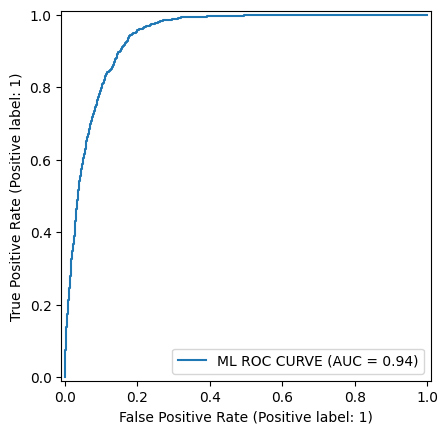

2025/03/06 13:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


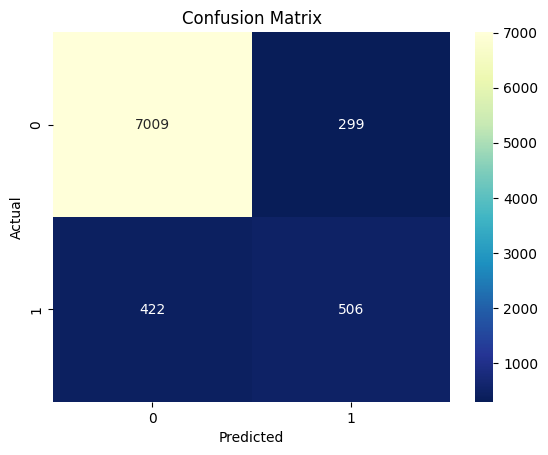

In [54]:
import torch

with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = 'relu'
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)    
    mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "None")

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print("Split " + str(i+1))
        X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        # model set
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)
        
        # model inference on test set
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
        
        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
        print(i, " precision, recall, f1score : ", prf_score_test)
        print(i, " roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation data set 
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]
        
        # score evaluation on validation data set 
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
        print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation_macro)


    def get_prf_average(list_of_result):
        pre = 0
        rec = 0
        f1 = 0
        for result in list_fold_result_validation:
            pre += result[0]
            rec += result[1]
            f1 += result[2]
        return pre/n_split, rec/n_split, f1/n_split
            
    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)
    
    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split
    
    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)
    
    
    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)
    
    
    def save_artifact(model, X_validation, y_validation, y_pred):
        roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
        plt.savefig('model_roc_plot.png')
        plt.show()
        plt.clf()
        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.savefig('model_conf_matrix.png')
        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')
    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
    mlflow.sklearn.log_model(rf_clf, "model")
    
        
mlflow.end_run()
    